In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/GANs'

In [27]:
%cd '/content/drive/MyDrive/GANs'

/content/drive/MyDrive/GANs


In [28]:
!pwd

/content/drive/MyDrive/GANs


In [29]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

In [31]:
mu1, sig1 = [-5. , -5.], 1.
mu2, sig2 = [5. , 5.], 1.
mu3, sig3 = [-5. , 5.], 1.
NOISE_DIM = 2  # What is the dimension of the noise

In [32]:
def get_uniform(batch_size):
  return torch.rand(batch_size, NOISE_DIM)

def plot_2d_density(xy):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.kdeplot(x=xy[:, 0], y=xy[:, 1], cut=5, cmap=cmap, label="pdata")

def sample_real_data(batch_size):
  n1, n2 = int(batch_size/3), int(batch_size/3)
  n3 = batch_size-n1-n2

  data = np.vstack([
      np.random.normal(mu1, sig1, (n1,2)),
      np.random.normal(mu2, sig2, (n2,2)),
      np.random.normal(mu3, sig3, (n3,2))
  ])
  return torch.FloatTensor(data)

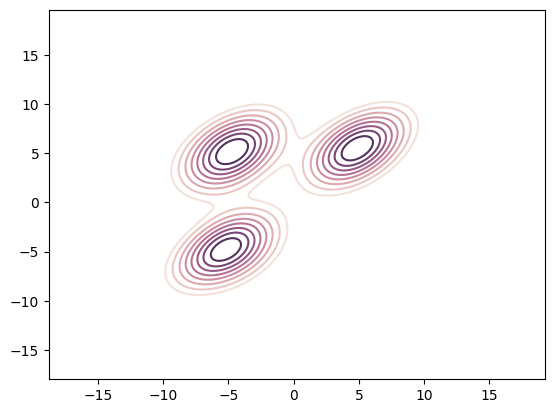

In [33]:
plot_2d_density(sample_real_data(64).data.numpy())

In [34]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features=NOISE_DIM, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=2)
    )

  def forward(self, x):
    return self.main(x)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features=2, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)

gen = Generator()
disc = Discriminator()

In [35]:
generator_opt = torch.optim.SGD(gen.parameters(), lr = 1e-3)
discriminator_opt = torch.optim.SGD(disc.parameters(), lr = 1e-3)

In [36]:
def update_D(batch_size):
  real_samples = sample_real_data(batch_size)
  prob_real_is_real = disc(real_samples)

  noise = get_uniform(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_fake = 1 - disc(generated_samples)

  loss = (-torch.log(prob_real_is_real)- torch.log(prob_fake_is_fake)).mean()

  discriminator_opt.zero_grad()
  loss.backward()
  discriminator_opt.step()

  return loss.data.numpy().item()

In [37]:
def update_G(batch_size):
  noise = get_uniform(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_real = disc(generated_samples)

  loss = (-torch.log(prob_fake_is_real)).mean()

  generator_opt.zero_grad()
  loss.backward()
  generator_opt.step()

  return loss.data.numpy().item()

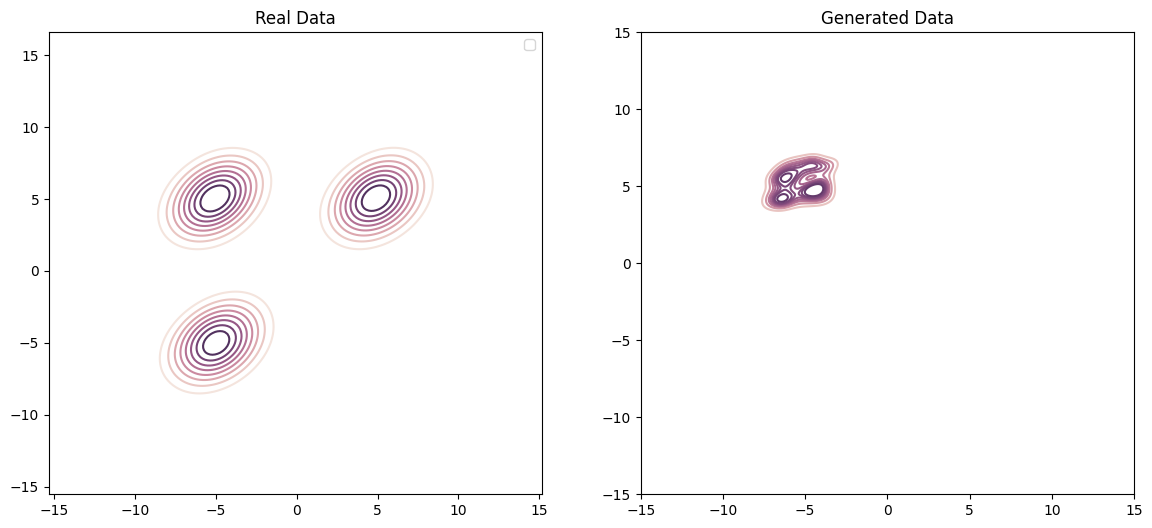

In [38]:
N_DISC_OPERATIONS = 5
BATCH_SIZE = 64

for i in range(10000):

  for _ in range(N_DISC_OPERATIONS):
    update_D(BATCH_SIZE)

  update_G(BATCH_SIZE)

  if i % 300 == 0:
    clear_output(True)
    plt.figure(figsize=[14,6])
    plt.subplot(1,2,1)
    plt.title("Real Data")
    plot_2d_density(sample_real_data(1000).data.numpy())
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("Generated Data")

    plot_2d_density(gen(get_uniform(100)).data.numpy())

    axes = plt.gca()
    axes.set_ylim([-15,15])
    axes.set_xlim([-15,15])


    plt.show()